In [1]:
import statistics
import matplotlib.pyplot as pyplot
import math
import numpy
import scipy.stats
import random
%matplotlib inline


In [2]:
size = 50
alpha = 0.05
beta_probability = 1 - alpha # доверительная вероятность
x = numpy.array([0.5, 0.56, 0.61, 0.65, 0.71, 0.75, 0.79, 0.84, 0.92, 0.94, 0.98, 1.06, 1.09, 1.19, 1.2, 1.29, 1.32, 1.36, 1.39, 1.46,
    1.54, 1.57, 1.62, 1.69, 1.74, 1.76, 1.79, 1.85, 1.95, 1.98, 2.05, 2.07, 2.1, 2.18, 2.21, 2.29, 2.34, 2.42, 2.46, 2.48,
     2.53, 2.56, 2.62, 2.67, 2.75, 2.82, 2.81, 2.91, 2.95, 3.03])
y = numpy.array([7.34,3.32,6.11,5.65,8.99,4.94,6.9,4.95,7.08,6.26,4.77,8.21,6.55,4.41,4.86,3.38,3.21,2.69,6.57,3.73,
     5.43,2.72,3.08,5.13,5.0,1.39,3.75,1.67,4.06,1.37,3.7,-0.61,-2.81,-0.32,-1.68,-3.37,0.36,-4.1,-2.21,-3.45,
     -5.08,-6.45,-2.7,-1.23,-10.51,-10.57,-4.42,-4.71,-4.01,-7.87])


## 1) выборочный коэффициент корреляции r

In [3]:
var_x = numpy.var(x) #дисперсия
cov_xy = numpy.cov(x,y, bias = True)[0][1]
var_y = numpy.var(y)
r = cov_xy/(math.sqrt(var_x * var_y))
print( "Выборочный коэффициент корреляции = ", r )

Выборочный коэффициент корреляции =  -0.8845625988243726


In [4]:
norm_rv = scipy.stats.norm(loc=0, scale=1)
quantile_norm = norm_rv.ppf(1-alpha/2)
if abs(r) >= math.tanh(quantile_norm/math.sqrt(size-3)):
    print("Опровергаем гипотезу, что r = 0 с вероятностью ",1-alpha)
else:
    print("Гипотеза о существовании линейной связи между x и y не подтверждается")

Опровергаем гипотезу, что r = 0 с вероятностью  0.95


## 2) уравнение лин регрессии и проверка значимости коэффициентов

In [5]:
def f1(x):
    return x-1
def f2(x):
    return x**2
def f3(x):
    return x**(1/3)

In [6]:
psi = numpy.column_stack((f1(x),f2(x),f3(x))) #матрица наблюдений
f = numpy.dot( psi.transpose(),psi ) # или R = A @ B @ C 
f_reversed = numpy.linalg.inv(f)
beta = f_reversed @ psi.transpose() @ y.transpose()
print("Уравнение линейной регрессии y =",beta[0],"* (x-1) +",beta[1],"* (x^2) +",beta[2],"* x^(1/3)")
def linear_regression(x):
    return beta[0]*f1(x) + beta[1]*f2(x) + beta[2]*f3(x)

Уравнение линейной регрессии y = -1.1823442710676093 * (x-1) + -1.8737093842211485 * (x^2) + 7.689352740929896 * x^(1/3)


In [7]:
RSS = ( y - ( psi @ beta) ) @ ( y - ( psi @ beta) )
RSS_old = RSS.copy()
p = numpy.linalg.matrix_rank(psi)  # ранг матрицы пси
p_old = p.copy()
student_rv = scipy.stats.t(size - p )  #стьюдент
quantile_t = student_rv.ppf(1-alpha/2)
print("H0: beta[i] = 0")
for i in range(3):
    temp = quantile_t * math.sqrt(RSS * f_reversed[i][i]/(size - p))
    print("Критическая область: abs(beta[{}]) =  ".format(i), abs(beta[i]), " > ", temp)
    if abs(beta[i]) > temp:
        print("Отклоняем H0 ( т.е коэффициент не равен 0 ) -> коэффициент значим")
    else:
        print("Принимаем H0 -> коэффициент не значим")

H0: beta[i] = 0
Критическая область: abs(beta[0]) =   1.1823442710676093  >  3.827025667210669
Принимаем H0 -> коэффициент не значим
Критическая область: abs(beta[1]) =   1.8737093842211485  >  1.1305186646747083
Отклоняем H0 ( т.е коэффициент не равен 0 ) -> коэффициент значим
Критическая область: abs(beta[2]) =   7.689352740929896  >  1.366899092400253
Отклоняем H0 ( т.е коэффициент не равен 0 ) -> коэффициент значим


## 3) Оценка дисперсии ошибок и доверительный интервал для дисперсии ошибок

In [8]:
sigma = RSS / ( size-p )
chi2_rv = scipy.stats.chi2(size - p)
quantile_chi2_a = chi2_rv.ppf((1-beta_probability)/2)
quantile_chi2_b = chi2_rv.ppf((1+beta_probability)/2)
print("Доверительная вероятность =", beta_probability)
print("Доверительный интервал: {} < {} < {}".format(RSS/quantile_chi2_b,sigma,RSS/quantile_chi2_a))

Доверительная вероятность = 0.95
Доверительный интервал: 2.871494265981603 < 4.143544658094541 < 6.501045760227614


## 4) Коэффициент детерминации и проверка его значимости

In [9]:
RSS_0 = numpy.var(y) * size
R = (RSS_0 - RSS)/RSS_0 # коэф детерминации
print("{} % - доля дисперсии Y, которая объясняется регрессией ".format(R*100))
fisher_rv = scipy.stats.f(p-1, size - p)
quantile_f = fisher_rv.ppf(1-alpha)
G_cr = (RSS_0 - RSS)/RSS*(size - p)/(p-1)
print("Критическая область: {} > {}".format(G_cr,quantile_f))
if G_cr > quantile_f:
    print("Принимаем H_1: регрессия является значимой")
else:
    print("Принимаем H_0: регрессия не является значимой")

83.54785556204422 % - доля дисперсии Y, которая объясняется регрессией 
Критическая область: 119.33852228883012 > 3.195056280737215
Принимаем H_1: регрессия является значимой


## 5) Проверка предположения о независимости ошибок измерения

In [10]:
eps = y - linear_regression(x)
norm_rv = scipy.stats.norm(loc=0, scale=1)
quantile_norm = norm_rv.ppf(1-alpha/2)
#ищем количество инверсий
I = 0
for i in range(size):
    for j in range(i,size):
        if eps[j]<eps[i]:
            I+=1
M_I = size*(size-1)/4
D_I = (size**3)/36
temp = (I-M_I)/math.sqrt(D_I)
print("Критическая область: {} > {}".format(abs(temp),quantile_norm))
if abs(temp) > quantile_norm:
    print("Попали в критическую область -> принимаем H1: ошибки неслучайны -> eps зависимы")
else:
    print("Не попали в критическую область -> принимаем H0: ошибки случайны -> eps независимы")

Критическая область: 0.17819090885900998 > 1.959963984540054
Не попали в критическую область -> принимаем H0: ошибки случайны -> eps независимы


## 6) Проверка предположения о нормальности распределения ошибок

In [11]:
k = 1 + numpy.log(size)

## 7) Доверительная полоса для уравнения регрессии + графики

In [12]:
psi = numpy.column_stack((f1(x),f2(x),f3(x))) #матрица наблюдений
f = numpy.dot( psi.transpose(),psi ) # или R = A @ B @ C 
f_reversed = numpy.linalg.inv(f)
beta = f_reversed @ psi.transpose() @ y.transpose()
RSS = ( y - ( psi @ beta) ) @ ( y - ( psi @ beta) )
p = numpy.linalg.matrix_rank(psi)  # ранг матрицы пси
beta = f_reversed @ psi.transpose() @ y.transpose()
quantile_t = scipy.stats.t(size - p ).ppf(1-alpha/2) #стьюдент
def confidence_regression_bottom(x):
    fi = numpy.column_stack([f1(x),f2(x),f3(x)])
    A_temp = fi @ f_reversed @ fi.transpose()
    return linear_regression(x) - quantile_t*beta_probability*numpy.sqrt(1 + A_temp.diagonal() )*math.sqrt(RSS/(size-p))
def confidence_regression_upper(x):
    fi = numpy.column_stack([f1(x),f2(x),f3(x)])
    A_temp = fi @ f_reversed @ fi.transpose()
    return linear_regression(x) + quantile_t*beta_probability*numpy.sqrt(1 + A_temp.diagonal() )*math.sqrt(RSS/(size-p))
           

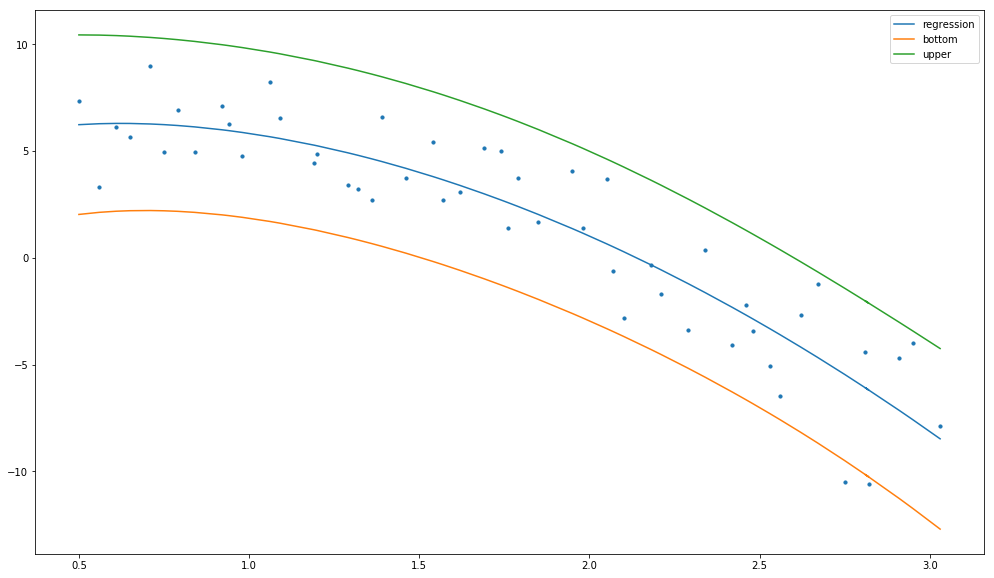

In [13]:
pyplot.figure( figsize=(17,10) )
pyplot.scatter(x,y,s=10)
pyplot.plot(x,linear_regression(x), label = "regression")
pyplot.plot(x,confidence_regression_bottom(x), label = "bottom")
pyplot.plot(x,confidence_regression_upper(x), label = "upper")
pyplot.legend(prop={'size': 40})
pyplot.legend()
pyplot.show()

## 8) Удалить незначимый коэффициент и повторить 2,3,4

Удаляем f1 = 1-x

In [14]:
# 1) выборочный коэффициент корреляции r
psi = numpy.column_stack((f2(x),f3(x))) #матрица наблюдений
f = numpy.dot( psi.transpose(),psi ) # или R = A @ B @ C 
f_reversed = numpy.linalg.inv(f)
beta = f_reversed @ psi.transpose() @ y.transpose()
print("Уравнение линейной регрессии y =",beta[0],"* (x^2) +",beta[1],"* x^(1/3)")
def linear_regression_new(x):
    return beta[0]*f2(x) + beta[1]*f3(x)

Уравнение линейной регрессии y = -2.212224077602007 * (x^2) + 7.96335161667931 * x^(1/3)


In [15]:
# 2) уравнение лин регрессии и проверка значимости коэффициентов
RSS = ( y - ( psi @ beta) ) @ ( y - ( psi @ beta) )
RSS_new = RSS.copy()
p = numpy.linalg.matrix_rank(psi)  # ранг матрицы пси
p_new = p.copy()
student_rv = scipy.stats.t(size - p )  #стьюдент
quantile_t = student_rv.ppf(1-alpha/2)
print("H0: beta[i] = 0")
for i in range(2):
    temp = quantile_t * math.sqrt(RSS * f_reversed[i][i]/(size - p))
    print("Критическая область: abs(beta[{}]) =  ".format(i), abs(beta[i]), " > ", temp)
    if abs(beta[i]) > temp:
        print("Отклоняем H0 ( т.е коэффициент не равен 0 ) -> коэффициент значим")
    else:
        print("Принимаем H0 -> коэффициент не значим")

H0: beta[i] = 0
Критическая область: abs(beta[0]) =   2.212224077602007  >  0.27644325889658006
Отклоняем H0 ( т.е коэффициент не равен 0 ) -> коэффициент значим
Критическая область: abs(beta[1]) =   7.96335161667931  >  1.032882438131383
Отклоняем H0 ( т.е коэффициент не равен 0 ) -> коэффициент значим


In [16]:
# 3)Оценка дисперсии ошибок и доверительный интервал для дисперсии ошибок
sigma = RSS / ( size-p )
chi2_rv = scipy.stats.chi2(size - p)
quantile_chi2_a = chi2_rv.ppf((1-beta_probability)/2)
quantile_chi2_b = chi2_rv.ppf((1+beta_probability)/2)
print("Доверительная вероятность =", beta_probability)
print("Доверительный интервал: {} < {} < {}".format(RSS/quantile_chi2_b,sigma,RSS/quantile_chi2_a))

Доверительная вероятность = 0.95
Доверительный интервал: 2.8446803371791898 < 4.0905665128568085 < 6.384339077746481


In [17]:
# 4) Коэффициент детерминации и проверка его значимости
RSS_0 = numpy.var(y) * size
R_new = (RSS_0 - RSS)/RSS_0 # коэф детерминации
print("{} % - доля дисперсии Y, которая объясняется регрессией ".format(R*100))
fisher_rv = scipy.stats.f(p-1, size - p)
quantile_f = fisher_rv.ppf(1-alpha)
G_cr = (RSS_0 - RSS)/RSS*(size - p)/(p-1)
print("Критическая область: {} > {}".format(G_cr,quantile_f))
if G_cr > quantile_f:
    print("Принимаем H_1: регрессия является значимой")
else:
    print("Принимаем H_0: регрессия не является значимой")

83.54785556204422 % - доля дисперсии Y, которая объясняется регрессией 
Критическая область: 241.37693306771476 > 4.042652128566653
Принимаем H_1: регрессия является значимой


In [18]:
# сравнить коэффициенты детерминации
fisher_rv = scipy.stats.f(p_old - p_new, size - p_old)
quantile_f = fisher_rv.ppf(1-alpha)
G_cr = (RSS_new-RSS_old)/RSS_old*(size-p_old)/(p_old-p_new)
print("H_0: усложение модели не значимо")
print("Критическая область: {} > {}".format(G_cr, quantile_f))
if G_cr > quantile_f:
    print("Попали в критическую область -> принимаем H1: то есть старая модель лучше")
else:
    print("Не попали в критическую область -> принимаем H0: то есть принимаем новую модель")

H_0: усложение модели не значимо
Критическая область: 0.386286095301661 > 4.0470998945817005
Не попали в критическую область -> принимаем H0: то есть принимаем новую модель


## 9) В новом базисе проверяем значимость коэффициентов регрессии и значимость коэффициента детерминации бутстрепом
        

In [36]:
# значимость коэффициентов регрессии бустрепом
k = 1000
sample_bootstrap_beta_0 = []
sample_bootstrap_beta_1 = []
for _ in range(k):
    bootstrap_i = numpy.array([random.randint(0,size-1) for _ in range(size)])
    bootstrap_x = x[bootstrap_i]
    bootstrap_y = y[bootstrap_i]
    bootstrap_psi = numpy.column_stack((f2(bootstrap_x),f3(bootstrap_x)))
    bootstrap_f = numpy.dot( bootstrap_psi.transpose(),bootstrap_psi )
    bootstrap_f_reversed = numpy.linalg.inv(bootstrap_f)
    bootstrap_beta = bootstrap_f_reversed @ bootstrap_psi.transpose() @ bootstrap_y.transpose()
    sample_bootstrap_beta_0.append(abs(beta[0]-bootstrap_beta[0]))
    sample_bootstrap_beta_1.append(abs(beta[1]-bootstrap_beta[1]))
sample_bootstrap_beta_0.sort()
sample_bootstrap_beta_1.sort()
delta_beta_0 = sample_bootstrap_beta_0[int(beta_probability*k)-1]
delta_beta_1 = sample_bootstrap_beta_1[int(beta_probability*k)-1]
print("H0: beta[i] = 0")
print("Критическая область: abs(beta[{}]) =  ".format(0), abs(beta[0]), " > ", delta_beta_0)
if abs(beta[0]) > delta_beta_0:
    print("Отклоняем H0 ( т.е коэффициент не равен 0 ) -> коэффициент значим")
else:
    print("Принимаем H0 -> коэффициент не значим")
print("Критическая область: abs(beta[{}]) =  ".format(1), abs(beta[1]), " > ", delta_beta_1)
if abs(beta[1]) > delta_beta_1:
    print("Отклоняем H0 ( т.е коэффициент не равен 0 ) -> коэффициент значим")
else:
    print("Принимаем H0 -> коэффициент не значим")

H0: beta[i] = 0
Критическая область: abs(beta[0]) =   2.212224077602007  >  0.315959207665617
Отклоняем H0 ( т.е коэффициент не равен 0 ) -> коэффициент значим
Критическая область: abs(beta[1]) =   7.96335161667931  >  0.8948816652887519
Отклоняем H0 ( т.е коэффициент не равен 0 ) -> коэффициент значим


In [ ]:
# значимость коэффициента детерминации бутстрепом
k = 1000

for _ in range(k):
    RSS_0 = numpy.var(y) * size
    R_new = (RSS_0 - RSS)/RSS_0 # коэф детерминации
    print("{} % - доля дисперсии Y, которая объясняется регрессией ".format(R*100))